# Image-audio ZSL evaluation

To evaluate our trained model, we first construct the model and load the saved weights.

## 1. Load the trained model

In [2]:
from zsl.model import ImageAudioSiameseNetwork
from zsl.loss import TripletLoss
from zsl.dataset import ImageAudioDataset
from zsl.data_prep import prepare_zsl_split_img_audio
from zsl.transforms import get_transforms
from zsl.model_manager import ModelManager
from zsl.utils import *

In [3]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [4]:
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import pandas as pd

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
siamese_network = ImageAudioSiameseNetwork().to(device)
triplet_loss = TripletLoss(0.5).to(device)
img_transforms, mel_transform = get_transforms()

In [9]:
optimizer_siamese = optim.Adam(siamese_network.parameters(), lr=0.01)
exp_lr_scheduler = ReduceLROnPlateau(
    optimizer_siamese, 
    mode='min', 
    factor=0.2, 
    patience=5, 
    verbose=True
)

In [10]:
curr_model = ModelManager(
    siamese_network, 
    triplet_loss, 
    optimizer_siamese, 
    exp_lr_scheduler, 
    device
)

In [11]:
curr_model.load_model('./checkpoints/img_audio_221128/w_ep-00195_l-0.0908.pth')

Loading model done: ./checkpoints/img_audio_221128/w_ep-00195_l-0.0908.pth


## 2. Prepare our data splits

In [12]:
(
    seen_img_classes,
    seen_img_path,
    seen_img_label,
    seen_audio_X_train, 
    seen_audio_y_train, 
    seen_audio_X_test, 
    seen_audio_y_test,
    unseen_img_classes,
    unseen_img_path,
    unseen_img_label,
    unseen_audio_X_train, 
    unseen_audio_y_train, 
    unseen_audio_X_test, 
    unseen_audio_y_test,
) = prepare_zsl_split_img_audio()

## 3. Seen class prediction (supervised learning)


### 3-1) Prepare the audio and image data from the seen classes.


In [13]:
seen_img_audio_dataset_tr = ImageAudioDataset(
    audio_path_list = seen_audio_X_train,
    audio_label_list = seen_audio_y_train,
    img_path_list = seen_img_path,
    img_label_list = seen_img_label,
    img_class_list = seen_img_classes,
    audio_transform = mel_transform,
    img_transform = img_transforms['test']
)
seen_img_audio_dataset_ts = ImageAudioDataset(
    audio_path_list = seen_audio_X_test,
    audio_label_list = seen_audio_y_test,
    img_path_list = seen_img_path,
    img_label_list = seen_img_label,
    img_class_list = seen_img_classes,
    audio_transform = mel_transform,
    img_transform = img_transforms['test']
)

In [15]:
seen_img_audio_dataloaders = {}
seen_img_audio_dataloaders['train'] = DataLoader(
    seen_img_audio_dataset_tr,
    batch_size=16, 
    num_workers=8,
    shuffle=False
)
seen_img_audio_dataloaders['test'] = DataLoader(
    seen_img_audio_dataset_ts,
    batch_size=16, 
    num_workers=8,
    shuffle=False
)

### 3-2) Compute the audio embeddings using ZSL model

In [16]:
(
    seen_ts_audio_embs, 
    seen_random_img_embs, 
    seen_ts_labels, 
    seen_ts_loss
) = curr_model.infer_all(seen_img_audio_dataloaders, 'test')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:11<00:00, 11.00it/s]

test Loss: 0.1437


### 3-3) Compute all image embeddings from seen class images using ZSL model

In [17]:
from PIL import Image
from collections import defaultdict
import torch.nn as nn

seen_all_img_embs = []
for i in tqdm(range(len(seen_img_path))):
    _img = img_transforms['test'](Image.open(seen_img_path[i])).unsqueeze(0).to(device)
    _img = nn.Sigmoid()(curr_model.model.visual_model(_img))
    _img = torch.squeeze(_img, dim=-1)
    _img = torch.squeeze(_img, dim=-1)
    _img = curr_model.model.visual_projection(_img)
    seen_all_img_embs.append(_img.squeeze().detach().cpu().numpy())
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 51.99it/s]


### 3-4)  Compute the mean image embedding vector for each class

- Unlike the previous word-audio experiment, we need to get **the mean embedding vector** from images of a certain class. 

In [18]:
seen_class_to_img_embs = defaultdict(list)   
for i in tqdm(range(len(seen_all_img_embs))):
    seen_class_to_img_embs[seen_img_label[i]].append(seen_all_img_embs[i])
seen_class_to_mean_img_emb = {}
for _c in seen_class_to_img_embs:
    seen_class_to_mean_img_emb[_c] = np.mean(seen_class_to_img_embs[_c], axis=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 1007035.77it/s]


### 3-5) Evaluate the test set audio on seen classes (supervised learning evaluation)

In [19]:
correct = 0
for idx in range(seen_ts_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(seen_ts_audio_embs[idx], 0), 
                                                  seen_class_to_mean_img_emb, 
                                                  seen_img_classes,
                                                  1)
    if seen_ts_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-1 acc :', correct / seen_ts_audio_embs.shape[0])

Top-1 acc : 0.8064516129032258


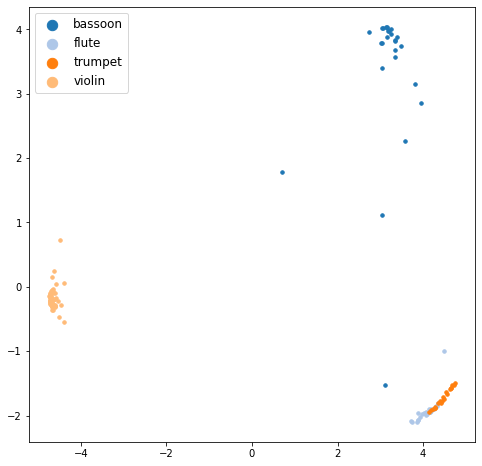

In [20]:
draw_pca(seen_ts_audio_embs, seen_ts_labels, seen_img_classes)

## 4. Unseen class prediction

### 4-1) Prepare the audio and image data from the unseen classes.

In [23]:
len(unseen_img_path), len(unseen_audio_X_train), len(unseen_img_label)

(800, 520, 800)

In [26]:
unseen_audio_X = unseen_audio_X_train + unseen_audio_X_test
unseen_audio_y = unseen_audio_y_train + unseen_audio_y_test

unseen_img_audio_dataset = ImageAudioDataset(
    audio_path_list = unseen_audio_X,
    audio_label_list = unseen_audio_y,
    img_path_list = unseen_img_path,
    img_label_list = unseen_img_label,
    img_class_list = unseen_img_classes,
    audio_transform = mel_transform,
    img_transform = img_transforms['test']
)

In [27]:
unseen_img_audio_dataloaders = {}
unseen_img_audio_dataloaders['all'] = DataLoader(
    unseen_img_audio_dataset,
    batch_size=16, 
    num_workers=8,
    shuffle=False
)

### 4-2) Compute the audio embeddings using ZSL model

In [29]:
(
    unseen_audio_embs, 
    unseen_random_img_embs, 
    unseen_labels, 
    unseen_loss
) = curr_model.infer_all(unseen_img_audio_dataloaders, 'all')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 650/650 [00:59<00:00, 10.91it/s]

all Loss: 0.3540


### 4-3) Compute the image embeddings  using ZSL model

In [30]:
unseen_all_img_embs = []
for i in tqdm(range(len(unseen_img_path))):
    _img = img_transforms['test'](Image.open(unseen_img_path[i])).unsqueeze(0).to(device)
    _img = nn.Sigmoid()(curr_model.model.visual_model(_img))
    _img = torch.squeeze(_img, dim=-1)
    _img = torch.squeeze(_img, dim=-1)
    _img = curr_model.model.visual_projection(_img)
    unseen_all_img_embs.append(_img.squeeze().detach().cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.09it/s]


In [25]:
# unseen_all_img_embs = []
# for i in tqdm(range(len(unseen_img_path))):
#     _img = img_transforms['test'](Image.open(unseen_img_path[i])).unsqueeze(0).to(device)
#     _img = nn.Sigmoid()(curr_model.model.visual_model(_img))
#     _img = torch.squeeze(_img, dim=-1)
#     _img = torch.squeeze(_img, dim=-1)
#     _img = curr_model.model.visual_projection(_img)
#     unseen_all_img_embs.append(_img.squeeze().detach().cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 51.38it/s]


### 4-4)  Compute the mean image embedding vector for each class

In [31]:
unseen_class_to_img_embs = defaultdict(list)   
for i in tqdm(range(len(unseen_all_img_embs))):
    unseen_class_to_img_embs[unseen_img_label[i]].append(unseen_all_img_embs[i])
unseen_class_to_mean_img_emb = {}
for _c in unseen_class_to_img_embs:
    unseen_class_to_mean_img_emb[_c] = np.mean(unseen_class_to_img_embs[_c], axis=0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 617036.26it/s]


### 4-5) Evaluate the audio on unseen classes (zero-shot evaluation)

In [32]:
correct = 0
for idx in range(unseen_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(unseen_audio_embs[idx], 0), 
                                                  unseen_class_to_mean_img_emb, 
                                                  unseen_img_classes,
                                                  1)
    if unseen_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-1 acc :', correct / unseen_audio_embs.shape[0])

Top-1 acc : 0.4153846153846154


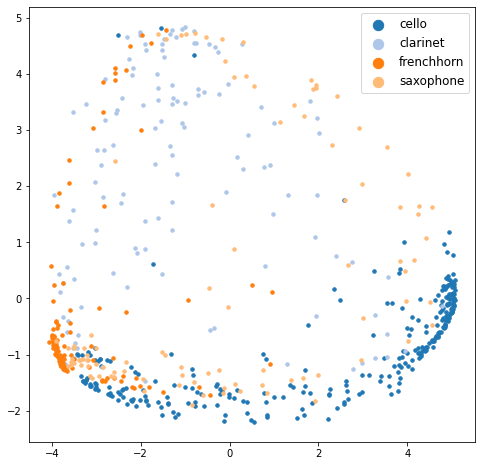

In [34]:
draw_pca(unseen_audio_embs, unseen_labels, unseen_img_classes)

## 5. Generalized ZSL evaluation

### 5-1) Concatenate the seen and unseen classes 

In [35]:
all_img_classes = seen_img_classes + unseen_img_classes

### 5-2) Prepare the audio embeddings, the image embeddings and their labels

In [36]:
added_unseen_labels = [_n + 4 for _n in unseen_labels]
added_unseen_img_label = [_n + 4 for _n in unseen_img_label]
all_img_embs = np.concatenate([seen_all_img_embs, unseen_all_img_embs])

In [33]:
# all_ts_audio_embs = np.concatenate([seen_ts_audio_embs, unseen_ts_audio_embs])
# all_img_embs = np.concatenate([seen_all_img_embs, unseen_all_img_embs])
# all_img_label = seen_img_label + added_unseen_img_label

In [32]:
# added_unseen_ts_labels = [_n + 4 for _n in unseen_ts_labels]
# added_unseen_img_label = [_n + 4 for _n in unseen_img_label]

In [34]:
# all_ts_labels = seen_ts_labels + added_unseen_ts_labels

### 5-3)  Compute the mean image embedding vector for each class

In [37]:
all_class_to_mean_img_emb = {}
for _c, _emb in seen_class_to_mean_img_emb.items():
    all_class_to_mean_img_emb[_c] = _emb
for _c, _emb in unseen_class_to_mean_img_emb.items():
    all_class_to_mean_img_emb[_c+4] = _emb

### 5-4) Evaluate the test set audio on seen + unseen classes (generalized zero-shot evaluation)

In [38]:
correct = 0
for idx in range(unseen_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(unseen_audio_embs[idx], 0), 
                                            all_class_to_mean_img_emb, 
                                            all_img_classes,
                                            1)
    if added_unseen_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-1 acc :', correct / unseen_audio_embs.shape[0])

Top-1 acc : 0.08


## 6. Visualize 

- test set seen class audio + whole set unseen class audio
- seen + unseen classes

In [41]:
all_audio_embs = np.concatenate([seen_ts_audio_embs, unseen_audio_embs])
all_labels = seen_ts_labels + added_unseen_labels

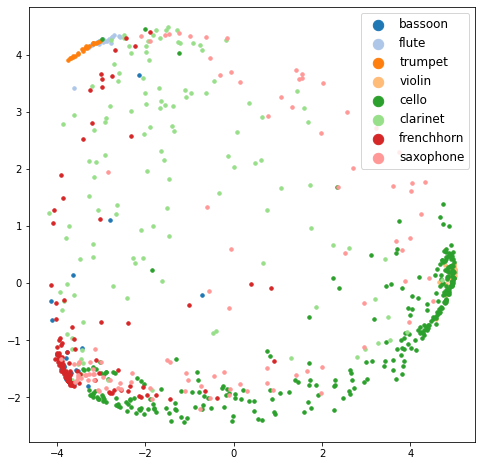

In [42]:
draw_pca(all_audio_embs, all_labels, all_img_classes)

### Looking into the mean image embeddings

How are the image embeddings formulated?

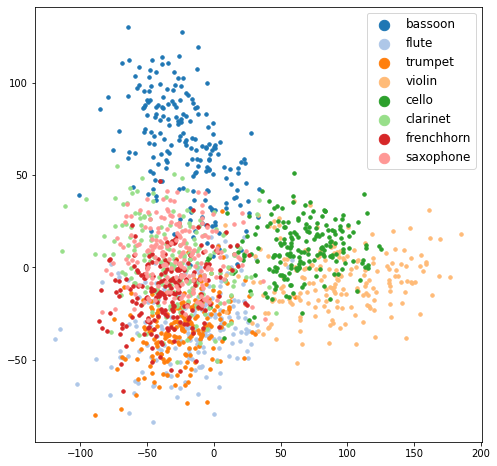

In [38]:
draw_pca(all_img_embs, all_img_label, all_img_classes)

In [44]:
all_img_mean_embs, all_img_mean_label = [], []
for _c in sorted(list(all_class_to_mean_img_emb.keys())):
    all_img_mean_embs.append(all_class_to_mean_img_emb[_c])
    all_img_mean_label.append(_c)

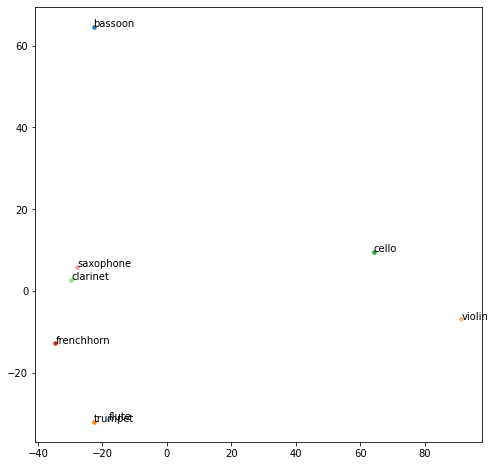

In [46]:
draw_pca_with_class(all_img_mean_embs, all_img_mean_label, all_img_classes)